# Postprocessing

### source: Overview and Benchmarking of Motion Detection Methods
DOI:10.1201/b17223-30, June 2014<br>
In book: Background Modeling and Foreground Detection for Video Surveillance<br>
Chapter: 24, Publisher: Chapman and Hall/CRC, Editors: T. Bouwmans and F. Porikli and B. Hoferlin and A. Vacavant<br>

> "A more classical, simpler and faster way to re-label pixels is throughout a post-processing filter. For example, Parks and Fels [132] consider a number of post-processing techniques to improve the segmentation map. Their results indicate that the performance is improved by morphological filters (closings), noise removal filter (such as median filters), and area filters.
Morphological filters are used to fill internal holes and small gaps, while area filters are used to remove small objects. In section 1.4.2, we present the results of some post-processing operations."

> "It appears that simple post-processing operations, such as the median or close/open morphological operations <ins>**always improve the segmentation map**</ins>"

> "It is thus recommended to include post-processing operations, even when comparing techniques. This was also the conclusion of Brutzer et al. [24] and Benezeth et al. [14]. Note that other filters can be used such as temporal filters, shadow filters [24], and complex spatio-temporal filtering techniques to re-label the classification results. However, it has been observed that not all post-processing filters do improve results [132]."

As we can read from the paper, usually a postprocessing step help with the enhancing of the foreground mask.

`Mog2` and `TemporalMedian` have already been "tuned" for our scenario but still the result have some problems.
- they both have spurious pixels due to noise
- the fgmask does not fill properly the real shape of the moving object

To address this task we can use different techniques varying from simple but powerful morphology operators to non-linear filters.

In this section we try to estabilish empirically what each operation can do and which combination could fit the best with our scenario.

In [224]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import cv2.bgsegm
from enum import Enum

In [225]:
video_path = "../video/rilevamento-intrusioni-video.wm"
cap = cv2.VideoCapture(video_path)

assert cap.isOpened(), "Not opened!"

fps = int(cap.get(cv2.CAP_PROP_FPS))
total_frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
length = total_frame_count / fps

width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

print(f"[I] Video FPS: {fps}")
print(f"[I] Video Total frame count: {total_frame_count}")
print(f"[I] Video Length: {length}")
print(f"[I] Video Frame Width: {width}")
print(f"[I] Video Frame height: {height}")

# Extract few difficult frames to perform comparisons
frameIds = [
    79,  # full body, mog2 partial shape, noise
    125, # sideways, poor filling in areas of the torso, noise
    314, # full body, books (both the removed and the added), noise
    502  # ghost due to long time in the same place
]
frames = []
for fid in frameIds:
    cap.set(cv2.CAP_PROP_POS_FRAMES, fid)
    ret, frame = cap.read()
    if frame is not None:
        frames.append(frame)


[I] Video FPS: 12
[I] Video Total frame count: 503
[I] Video Length: 41.916666666666664
[I] Video Frame Width: 320
[I] Video Frame height: 240


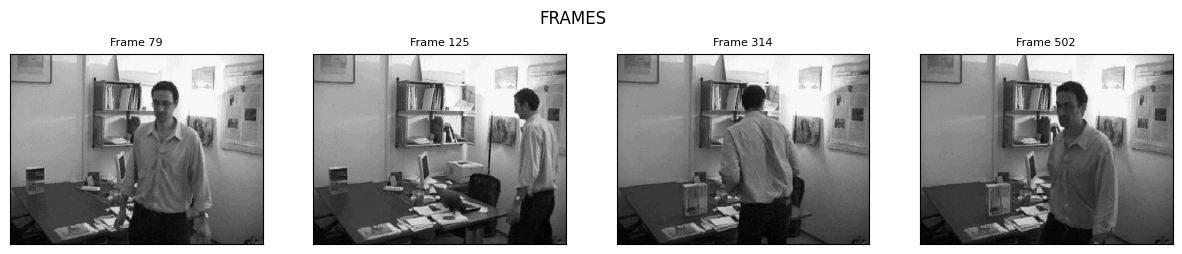

In [226]:
def show_subplots(title, frameIds, frames):
    fig, axs = plt.subplots(1, len(frames), figsize=(15, 2.5))
    fig.suptitle(title, ha='center',va='bottom')

    for i, ax, frame in zip(range(len(frames)), axs, frames):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        ax.set_title(f"Frame {frameIds[i]}", fontsize=8)
        ax.imshow(frame, cmap="grey")

    plt.show()

show_subplots("FRAMES", frameIds, frames)

In [227]:
class PreProcessingType(Enum):
    BILATERAL = 1

class PostProcessingType(Enum):
    ERODE = 1
    OPEN = 2
    DILATE = 3
    CLOSE = 4
    MEDIAN_BLUR = 5
    AREA_BASED = 6
    FILL_CONTOURS = 7
    APPROX_POLY = 8

In [228]:
def preprocessing(frame, type):
    """Apply all the preprocessing steps to a copy of the passed ``frame``.

    Applies a series of linear and non-linear filters base on the ``type`` passed.

    Parameters
    ----------
    frame : ndarray
        Grayscale input image.
    type : ProcessingType
        Instance of ProcessingType, it indicates which type of preprocessing will be applied.
        - ``ProcessingType.BILATERAL``

    Returns
    -------
    processed : ndarray
        A processed copy grayscale image.
    """
    assert isinstance(type, PreProcessingType), "type must be an instance of ProcessingType (Enum)"
    output = frame.copy()
    
    if type == PreProcessingType.BILATERAL:
        output = cv2.bilateralFilter(output, d=3, sigmaSpace=75, sigmaColor=75)
    else:
        raise ValueError("PreProcessingType.type not found")
    
    return output

In [229]:
def filled_contours(frame):
    """Find contours and redraw them filled in a copy of the passed `frame`

    Parameters
    ----------
    frame : ndarray
        Foreground mask input image.

    Returns
    -------
    processed : ndarray
        A processed copy the input image.
    """
    
    output = frame.copy()

    contours, _ = cv2.findContours(frame, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    # Draw contours on the original image
    cv2.drawContours(output, contours, -1, 255, cv2.FILLED)
    
    # cv2.imshow("filled", output)
    # cv2.waitKey(0)
    
    return output

In [230]:
def area_based(frame, min_area):
    """Find contours, apply a threshold on the minimum area and redraw them filled in a copy of the passed `frame`

    Parameters
    ----------
    frame : ndarray
        Foreground mask input image.

    Returns
    -------
    processed : ndarray
        A processed copy the input image.
    """
    # --------------
    # |  CONTOURS  |
    # --------------
    # cleaned_image = np.zeros_like(frame)
    # contours, _ = cv2.findContours(frame, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    # for contour in contours:
    #     if cv2.contourArea(contour) >= min_area:
    #         cv2.drawContours(cleaned_image, [contour], -1, (255), thickness=cv2.FILLED)

    # ----------------
    # |  COMPONENTS  |
    # ----------------
    # Find connected components with statistics
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(frame, connectivity=8)

    # Create an empty image to draw the filtered components
    cleaned_image = np.zeros_like(frame)

    # Loop through the components (excluding the background, which is label 0)
    for label in range(1, num_labels):
        area = stats[label, cv2.CC_STAT_AREA]
        if area >= min_area:
            # Draw the component on the filtered image
            cleaned_image[labels == label] = 255  # Set the pixels of the component to white
    
    # cv2.imshow("filled", output)
    # cv2.waitKey(0)
    
    return cleaned_image

In [231]:
def create_mask_from_approxPoly(frame, epsilon = 1.0):
    """Use approxPoly() to redraw the contour with less vertices.

    Parameters
    ----------
    frame : ndarray
        Foreground mask input image.
    epsilon : float
        Approximation accuracy. This is the maximum distance between the original curve and its approximation

    Returns
    -------
    processed : ndarray
        A processed copy the input image.
    """
    mask = np.zeros(frame.shape, np.uint8)
    
    output_image = frame.copy()

    contours, _ = cv2.findContours(frame, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    # Draw contours on the original image
    # cv2.drawContours(output_image, contours, -1, 255, cv2.FILLED)
    # cv2.imshow("filled", output_image)

    contours_poly = [ cv2.approxPolyDP(contour, epsilon, True) for contour in contours ]
    approx_poly = cv2.drawContours(mask, contours_poly, -1, 255, cv2.FILLED)
    # cv2.imshow("approx_poly", approx_poly)
    
    
    # cv2.waitKey(0)
    return approx_poly

In [232]:
def postprocessing(fgmask, type):
    """Apply, to a copy of the passed ``fgmask``, a pipeline of filters and morphological operators to improve the segmentation.

    Parameters
    ----------
    fgmask : ndarray
        Foreground mask input image.
    type : ProcessingType
        Instance of PostProcessingType, it indicates which type of preprocessing will be applied.
        - PostProcessingType.ERODE
        - PostProcessingType.OPEN
        - PostProcessingType.DILATE
        - PostProcessingType.CLOSE
        - PostProcessingType.MEDIAN_BLUR
        - PostProcessingType.AREA_BASED
        - PostProcessingType.FILL_CONTOURS
        - PostProcessingType.APPROX_POLY

    Returns
    -------
    processed : ndarray
        A processed copy the input image.
    """
    assert isinstance(type, PostProcessingType), "type must be an instance of ProcessingType (Enum)"
    output = fgmask.copy()

    if type == PostProcessingType.ERODE:
        element = np.ones((3,3), np.uint8)
        output = cv2.morphologyEx(output, cv2.MORPH_ERODE, element, iterations=1)

    elif type == PostProcessingType.OPEN:
        element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
        output = cv2.morphologyEx(output, cv2.MORPH_OPEN, element, iterations=1)

    elif type == PostProcessingType.DILATE:
        element = np.ones((3,3), np.uint8)
        output = cv2.dilate(output, element, iterations=2)
    
    elif type == PostProcessingType.CLOSE:
        element = np.ones((5,5), np.uint8)
        output = cv2.morphologyEx(output, cv2.MORPH_CLOSE, element, iterations=2)

    elif type == PostProcessingType.MEDIAN_BLUR:
        output = cv2.medianBlur(output, 3)

    elif type == PostProcessingType.FILL_CONTOURS:
        output = filled_contours(output)

    elif type == PostProcessingType.AREA_BASED:
        output = area_based(output, 100)

    elif type == PostProcessingType.APPROX_POLY:
        output = create_mask_from_approxPoly(output)

    else:
        raise ValueError("PostProcessingType.type not found")

    return output

In [233]:
# -------------------------------
# |           CONFIG            |
# -------------------------------
BLACK = 0
SHOW_GUI = False
font = cv2.FONT_HERSHEY_SIMPLEX
file_output = 'output.csv'
LEARNING_PHASE = 5 * fps                        # Initialization phase to estimate the reference frame

In [234]:
def create_mog2_background_subtractor():
    mog2 = cv2.createBackgroundSubtractorMOG2()
    mog2.setHistory(LEARNING_PHASE)
    mog2.setBackgroundRatio(70 / 100)               # cf=0.5 --> background_ratio=0.5
    mog2.setDetectShadows(True)
    mog2.setShadowThreshold(0.70)                   # A lower value may help in detecting more shadows.
    mog2.setShadowValue(BLACK)                      # Detect shadows and hide them
    mog2.setVarThreshold(5**2)                      # default: 16
    return mog2

mog2 = create_mog2_background_subtractor()

In [235]:
# apply mog2 background subtractor and save the fgmask only for those selected frames
def extract_fgmask_from_selected_frames(frameIds, fgmasks):
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    frame_count = 0
    while(cap.isOpened()):
        ret, frame_original = cap.read()
        if not ret or frame_original is None:
            cap.release()
            print("Released Video Resource")
            break

        frame = cv2.cvtColor(frame_original, cv2.COLOR_BGR2GRAY)
        frame = preprocessing(frame, PreProcessingType.BILATERAL)

        mog2_fgmask = mog2.apply(frame, -1)

        if frame_count in frameIds:
            fgmasks.append(mog2_fgmask)

        frame_count += 1

fgmasks = []
extract_fgmask_from_selected_frames(frameIds, fgmasks)

Released Video Resource


## 1. Morphological Operators

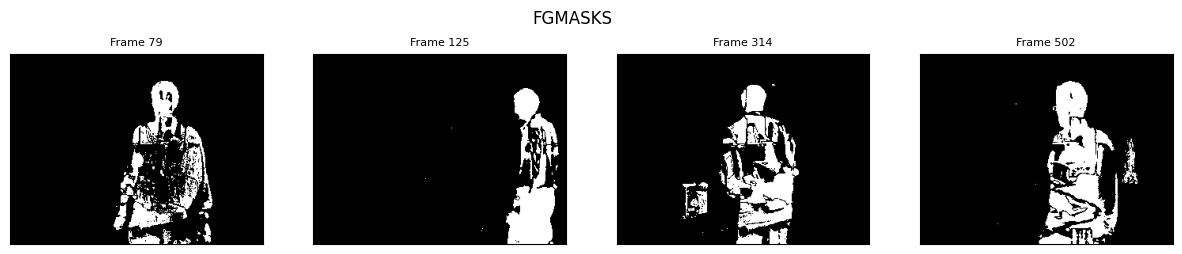

In [236]:
show_subplots("FGMASKS", frameIds, fgmasks)

### 1.1 DILATION
Directly applying the dilate morphological operator, without addressing small blobs due to noise, will only increase their size.

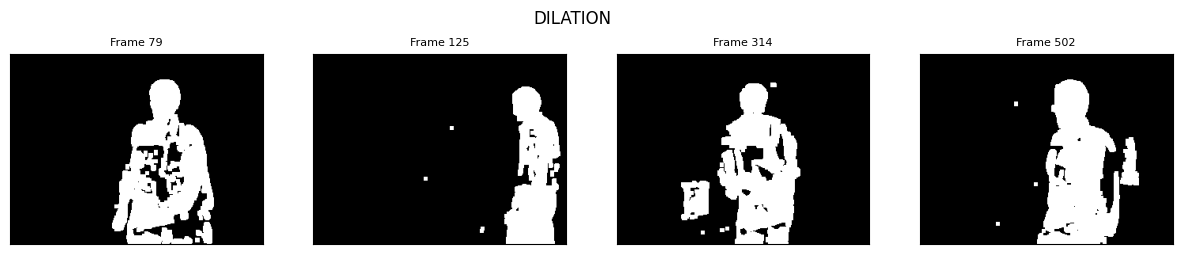

In [237]:
fgmasks_dilate = [ postprocessing(fgmask, type=PostProcessingType.DILATE) for fgmask in fgmasks ]
show_subplots("DILATION", frameIds, fgmasks_dilate)

### 1.2 CLOSING
To fill the shape completely, the closing operator is surely one of the most important postprocessing operator.<br> Like the dilation operator it should be applied only after the noise/small blobs removal.
We can't exaggerate nor with the number of iteration nor with the size of the structuring element, because it will rapidly degrade the shape/contour or the person.

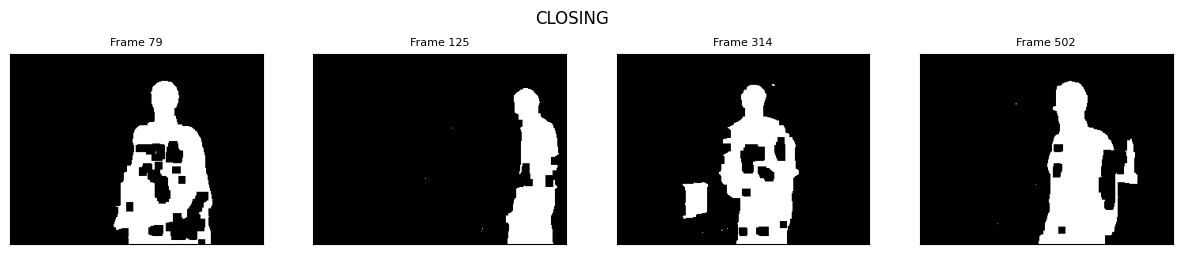

In [238]:
fgmasks_close = [ postprocessing(fgmask, type=PostProcessingType.CLOSE) for fgmask in fgmasks ]
show_subplots("CLOSING", frameIds, fgmasks_close)

### 1.3 OPENING
Using a structuring element of a small circle 3x3 we removed the noise blobs but we emptied the figure a lot, as we can see in the frame `79`.

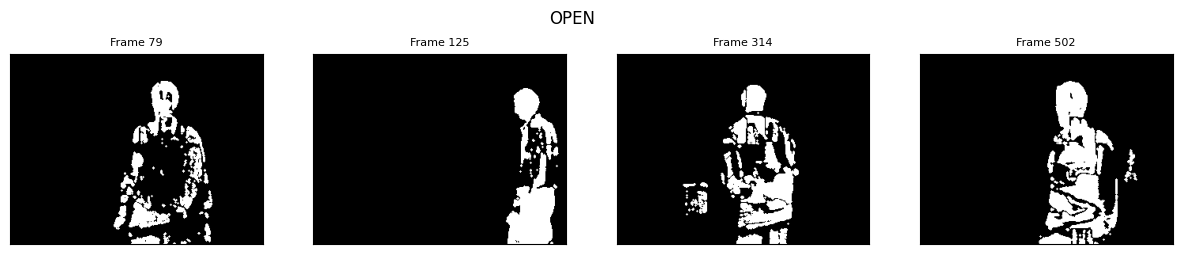

In [239]:
fgmasks_open = [ postprocessing(fgmask, type=PostProcessingType.OPEN) for fgmask in fgmasks ]
show_subplots("OPEN", frameIds, fgmasks_open)

### 1.4 EROSION
The erosion is degrading a lot the frame `79` because it is removing all the small parts that forms the torso.<br>
In general it could help in removing the noise but it thins out all the shapes.

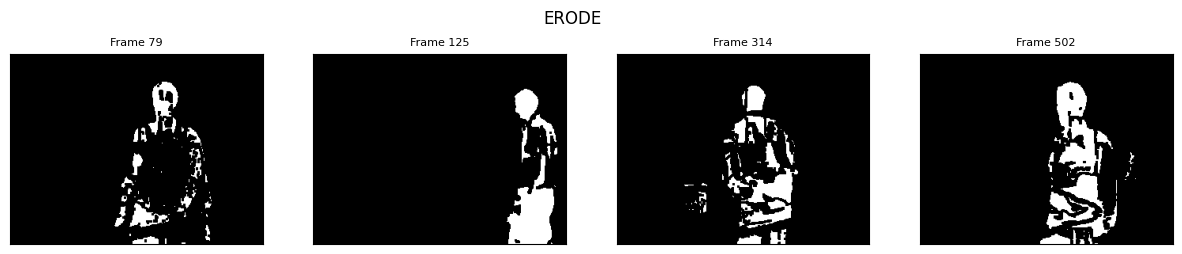

In [240]:
fgmasks_eroded = [ postprocessing(fgmask, type=PostProcessingType.ERODE) for fgmask in fgmasks ]
show_subplots("ERODE", frameIds, fgmasks_eroded)

## 2. FILTERS

### 2.1 MEDIAN

The non-linear median filter 3x3 could help addressing those small patches.<br>
Nevertheless, in the frame `79` will empty also the part of the torso and the chest.

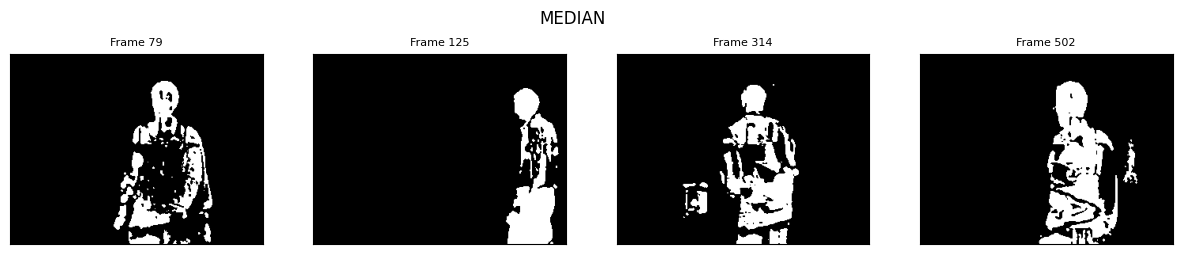

In [241]:
fgmasks_median = [ postprocessing(fgmask, type=PostProcessingType.MEDIAN_BLUR) for fgmask in fgmasks ]
show_subplots("MEDIAN", frameIds, fgmasks_median)

### 2.2 AREA BASED
Apply a filtering threshold based on the area of the [connected component | contour].
The processing is computationally more complex and the result is similar to the median filter.

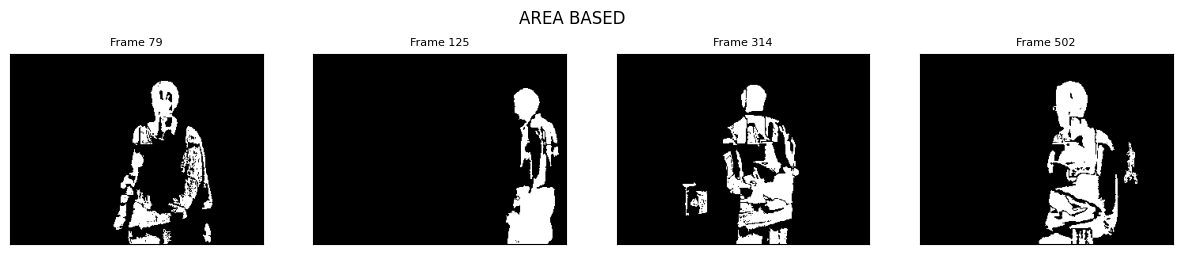

In [242]:
fgmasks_area = [ postprocessing(fgmask, type=PostProcessingType.AREA_BASED) for fgmask in fgmasks ]
show_subplots("AREA BASED", frameIds, fgmasks_area)

## 3. FILLING THE SHAPE

### 3.1 FILL CONTOURS
Redrawing the filled contours helps with closing the inner holes without using too many iteration of the morphological operators. In this example it will be applied after the dilation process.


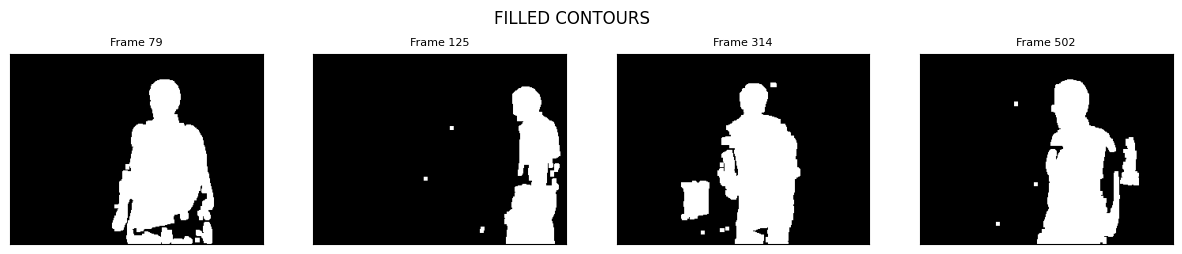

In [243]:
fgmasks_filled = [ postprocessing(fgmask, type=PostProcessingType.DILATE) for fgmask in fgmasks ]
fgmasks_filled = [ postprocessing(fgmask, type=PostProcessingType.FILL_CONTOURS) for fgmask in fgmasks_filled ]
show_subplots("FILLED CONTOURS", frameIds, fgmasks_filled)

### 3.2 APPROX POLY

The `approxPoly()` method redraws a curve with less vertices. <br>
We can take advantage of this to fill holes in the figure along the contour, it can help in closing the parts that "global" operator such the morphological ones cannot differentiate.
It is difficult to add a complete missing part of the body if the usual operators works the same at every pixel.

Using this operator we cannot exaggerate with the epsilon parameter otherwise the shape will be really edgy and pointy. The repetition of the same method in different steps can help each time a bit without degrading too much the overall shape.

In general this approach is not recommended because the enhancement is marginal and it would not be profitable with respect to the amount of overhead in computation.

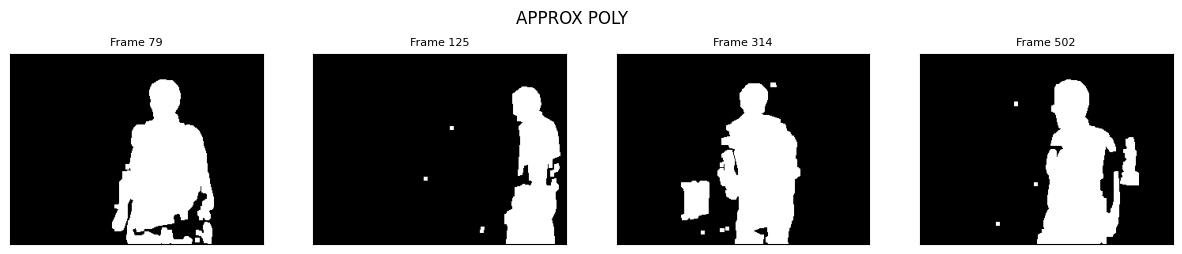

In [244]:
fgmasks_approx_poly = [ postprocessing(fgmask, type=PostProcessingType.DILATE) for fgmask in fgmasks ]
fgmasks_approx_poly = [ postprocessing(fgmask, type=PostProcessingType.APPROX_POLY) for fgmask in fgmasks_approx_poly ]
cv2.destroyAllWindows()
show_subplots("APPROX POLY", frameIds, fgmasks_approx_poly)

## 4. COMBINATIONS

The overall postprocessing step could be summarized in three main steps:
1.  denoise
2.  add pixels to have a better shape
3. fill the shape


We decided to use for the denoising part the `median blur`. <br>
The phase two was entrusted to the `dilation` and `closing` morphological operators and finally the third step is encapsulated in the `approxPoly()` method that will redraw the approx. contours with the `cv2.FILLED`.

The overall configuration of the operators depends on which mask are we working on, but the order of the steps remains the same, but it is possible to skip some of these if they are not necessary.

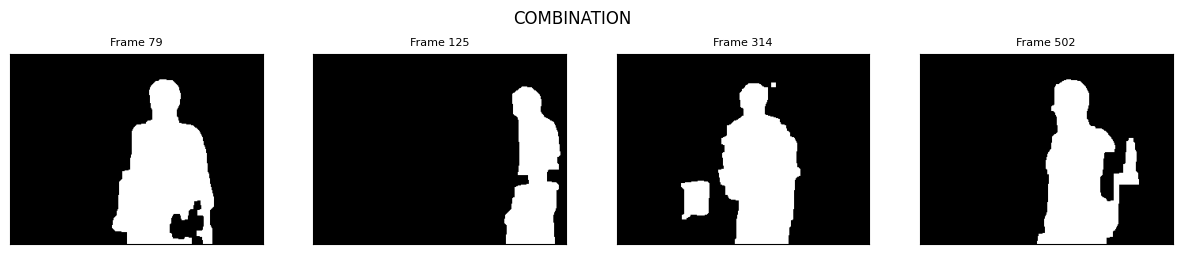

In [245]:
# PHASE 1: denoising
fgmasks_comb = [ postprocessing(fgmask, type=PostProcessingType.MEDIAN_BLUR) for fgmask in fgmasks ]

# PHASE 2: adding pixels
fgmasks_comb = [ postprocessing(fgmask, type=PostProcessingType.DILATE) for fgmask in fgmasks_comb ]
fgmasks_comb = [ postprocessing(fgmask, type=PostProcessingType.CLOSE) for fgmask in fgmasks_comb ]

# PHASE 3: filling the shape
fgmasks_comb = [ postprocessing(fgmask, type=PostProcessingType.APPROX_POLY) for fgmask in fgmasks_comb ]

show_subplots("COMBINATION", frameIds, fgmasks_comb)


**NOTE:** The results shown in this section are only partials and *not* the final processeds frame by the algorithm. <br>
For example, to better fill the person we also combine the masks of two different algorithms with two different time horizons, i.e. the `mog2` and `temporalMedian`.<br>
Furthermore, in the context of the connected components analysis we will also disard blobs based on the area.